### Training RNN using World's data

This is based on `COVID-19 growth prediction using multivariate
long short term memory` by `Novanto Yudistira`

https://arxiv.org/pdf/2005.04809.pdf

https://github.com/VICS-CORE/lstmcorona/blob/master/lstm.py

- We've aligned all countries' inputs rather than taking an absolute timeline. We start when cumulative number of confirmed cases in the country has crossed 100.
- We've normalised data by dividing by a population factor. That way the network can learn a general understanding of the pattern irrespective of the country's population.
- Rather than using the entire timeline as an input as suggested by NYudistira, we're training a fixed window (e.g. 20 days) so that the model learns to predict the future by looking at present data. The problem with fixed window approach is that some countries have peaked, while others have not. Also few countries start early, and some start late.
- The paper uses a multivariate network with confirmed, recovered and deceased data. However this'd increase computation time and hence we're restricting ourselves to a univariate model with confirmed cases as the only parameter.

#### Other ideas
- One idea is to train the current net with only the most populous countries' data, since their behaviour would be similar to India's.
- Adding metrics like humidity, population density, lockdown intensity etc might be beneficial and should have some correlation with the growth in cases. But this'd need more computation power.
- Another idea is to train a neuralnet to predict SIR like buckets.

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import torch
import json

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DayLocator, AutoDateLocator, ConciseDateFormatter
%matplotlib inline

In [2]:
CUDA="cuda:0"
CPU="cpu"
if torch.cuda.is_available():
    device = torch.device(CUDA)
    cd = torch.cuda.current_device()
    print("Num devices:", torch.cuda.device_count())
    print("Current device:", cd)
    print("Device name:", torch.cuda.get_device_name(cd))
    print("Device props:", torch.cuda.get_device_properties(cd))
    print(torch.cuda.memory_summary(cd))
else:
    device = torch.device(CPU)
print(device)

cpu


In [3]:
# define paths
DATA_DIR = 'data'
MODELS_DIR = 'models'

### Colab only

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd 'drive/My Drive/CS/colab/'

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!cat /proc/meminfo

### Read OWID data

In [4]:
!curl https://covid.ourworldindata.org/data/owid-covid-data.csv --output data/owid-covid-data.csv

In [5]:
!head -n1 data/owid-covid-data.csv

iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy


In [4]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population']
dates = ['date']
df = pd.read_csv(DATA_DIR + "/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population
20405,Rwanda,2020-04-29,212.0,5.0,0.0,0.0,12952209.0


### LSTM

In [5]:
class YudistirNet(tnn.Module):
    def __init__(self, ip_seq_len=1, op_seq_len=1, hidden_size=1, num_layers=1):
        super(YudistirNet, self).__init__()
        
        self.ip_seq_len = ip_seq_len
        self.op_seq_len = op_seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.linear = tnn.Linear(self.hidden_size * self.ip_seq_len, self.op_seq_len)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip):
        lstm_out, _ = self.lstm(ip)
        linear_out = self.linear(lstm_out.reshape(-1, self.hidden_size * self.ip_seq_len))
        sigmoid_out = self.sigmoid(linear_out.view(-1, self.op_seq_len))
        return sigmoid_out
    
    def predict(self, ip):
        with torch.no_grad():
            preds = self.forward(ip)
        return preds

### Checkpoint methods

In [6]:
def save_checkpoint(epoch, model, optimizer, trn_losses, val_losses, min_val_loss, path=""):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'trn_losses': trn_losses,
        'val_losses': val_losses,
        'min_val_loss': min_val_loss
    }, path or MODELS_DIR + "/latest.pt")
    print("Checkpoint saved")
    
def load_checkpoint(path="", device="cpu"):
    cp = torch.load(path or MODELS_DIR + "/latest.pt", map_location=device)
    print("Checkpoint loaded")
    return cp['epoch'], cp['model_state_dict'], cp['optimizer_state_dict'], cp['trn_losses'], cp['val_losses'], cp.get('min_val_loss', np.Inf)

### Config

In [7]:
# config
IP_SEQ_LEN = 40
OP_SEQ_LEN = 20

BATCH_SIZE = 1
VAL_RATIO = 0.3

HIDDEN_SIZE = 20
NUM_LAYERS = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 3001

# to continue training on another model, set resume to true
RESUME = False

model = YudistirNet(ip_seq_len=IP_SEQ_LEN, op_seq_len=OP_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
model = model.to(device)

loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

27940

### Prepare dataset

In [ ]:
def gen_dataset():
    ip_trn = []
    op_trn = []

    countries = df['location'].unique()
    pop_countries = ['China', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Bangladesh', 'Russia', 'Mexico']

    c = 0
    for country in countries:
        if country in ['World', 'International', 'India']: # Countries to be skipped
            continue
        country_df = df.loc[df.location == country]
        tot_cases_gt_100 = (country_df['total_cases'] >= 100)
        country_df = country_df.loc[tot_cases_gt_100]

        if len(country_df) >= IP_SEQ_LEN + OP_SEQ_LEN:
            c += 1
            pop = country_df['population'].iloc[0]
            print(c, country, len(country_df), pop)
            daily_cases = np.array(country_df['new_cases'].rolling(7, center=True, min_periods=1).mean() * 1000 / pop, dtype=np.float32)

            for i in range(len(country_df) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
                ip_trn.append(daily_cases[i : i+IP_SEQ_LEN])
                op_trn.append(daily_cases[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])

    ip_trn = torch.from_numpy(np.array(ip_trn, dtype=np.float32))
    op_trn = torch.from_numpy(np.array(op_trn, dtype=np.float32))
    dataset = tdt.TensorDataset(ip_trn, op_trn)

    val_len = int(VAL_RATIO * len(dataset))
    trn_len = len(dataset) - val_len
    trn_set, val_set = tdt.random_split(dataset, (trn_len, val_len))
    return trn_set, val_set

try:
    ds = torch.load(DATA_DIR + '/ds.pt')
    trn_set, val_set = ds['trn'], ds['val']
    print("Loaded dataset from ds.pt")
except FileNotFoundError:
    trn_set, val_set = gen_dataset()
    torch.save({'trn': trn_set, 'val': val_set}, DATA_DIR + '/ds.pt')
    print("Saved dataset to ds.pt")
finally:
    print("Training data:", len(trn_set), "Validation data:", len(val_set))

In [ ]:
trn_loader = tdt.DataLoader(trn_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = tdt.DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

### Train

In [ ]:
trn_loss_vals = []
val_loss_vals = []
e = 0
min_val_loss = np.Inf

if RESUME:
    e, model_dict, optimizer_dict, trn_loss_vals, val_loss_vals, min_val_loss = load_checkpoint(device=device)
    e+=1
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optimizer_dict)

# TRAIN
print("BEGIN: [", dt.datetime.now(), "]")
while e < NUM_EPOCHS:
    model.train()
    trn_losses = []
    for data in trn_loader:
        ip, op = data
        ip = ip.to(device)
        op = op.to(device)
        optimizer.zero_grad() # set grads to 0
        preds = model(ip.view(-1, IP_SEQ_LEN, 1)) # predict
        loss = loss_fn(preds, op.view(-1, OP_SEQ_LEN)) # calc loss
        loss.backward() # calc and assign grads
        optimizer.step() # update weights
        trn_losses.append(loss) # logging
    avg_trn_loss = torch.stack(trn_losses).mean().item() * 10000
    trn_loss_vals.append(avg_trn_loss)
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data in val_loader:
            ip, op = data
            ip = ip.to(device)
            op = op.to(device)
            preds = model(ip.view(-1, IP_SEQ_LEN, 1))
            loss = loss_fn(preds, op.view(-1, OP_SEQ_LEN))
            val_losses.append(loss)
        avg_val_loss = torch.stack(val_losses).mean().item() * 10000
        val_loss_vals.append(avg_val_loss)
    
    if e%10==0:
        print("[", dt.datetime.now(), "] epoch:", f"{e:3}", "avg_val_loss:", f"{avg_val_loss: .5f}", "avg_trn_loss:", f"{avg_trn_loss: .5f}")
        if e%100==0:
            save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, MODELS_DIR + "/latest-e" + str(e) + ".pt")
        if avg_val_loss <= min_val_loss:
            min_val_loss = avg_val_loss
            save_checkpoint(e, model, optimizer, trn_loss_vals, val_loss_vals, min_val_loss, MODELS_DIR + "/best-e" + str(e) + ".pt")
    e+=1
print("END: [", dt.datetime.now(), "]")

### Load saved model for evaluation

In [9]:
# model_path = MODELS_DIR + "/IP20_OP10_H10_L4_E2001_LR001.pt"
model_path = "/home/mayank/Downloads/ds4020-e17xx.pt"#ds4020-0612-e50x.pt"
e, md, _, trn_loss_vals, val_loss_vals, _ = load_checkpoint(model_path, device=device)
print(e)
model.load_state_dict(md)
model.eval()

Checkpoint loaded
1740


YudistirNet(
  (lstm): LSTM(1, 20, num_layers=4, batch_first=True)
  (linear): Linear(in_features=800, out_features=20, bias=True)
  (sigmoid): Sigmoid()
)

### Plot losses

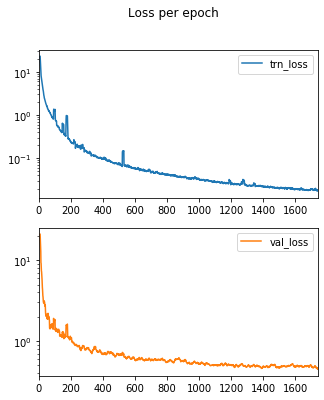

In [10]:
df_loss = pd.DataFrame({
    'trn_loss': trn_loss_vals,
    'val_loss': val_loss_vals
})
df_loss['trn_loss'] = df_loss['trn_loss'].rolling(10).mean()
df_loss['val_loss'] = df_loss['val_loss'].rolling(10).mean()
_ = df_loss.plot(
    y=['trn_loss', 'val_loss'],
    title='Loss per epoch',
    subplots=True,
    figsize=(5,6),
    sharex=False,
    logy=True
)

### Evalute fit

Element wise accuracy: [92.94578438 93.53638795 93.35306526 93.01170173 91.47305395 89.48152992
 87.74038151 86.46524096 86.04700009 85.79036415 85.45745161 85.28791574
 85.27865334 85.74340914 85.79362475 85.39168244 84.82734342 84.83194711
 84.59018017 84.27272083]


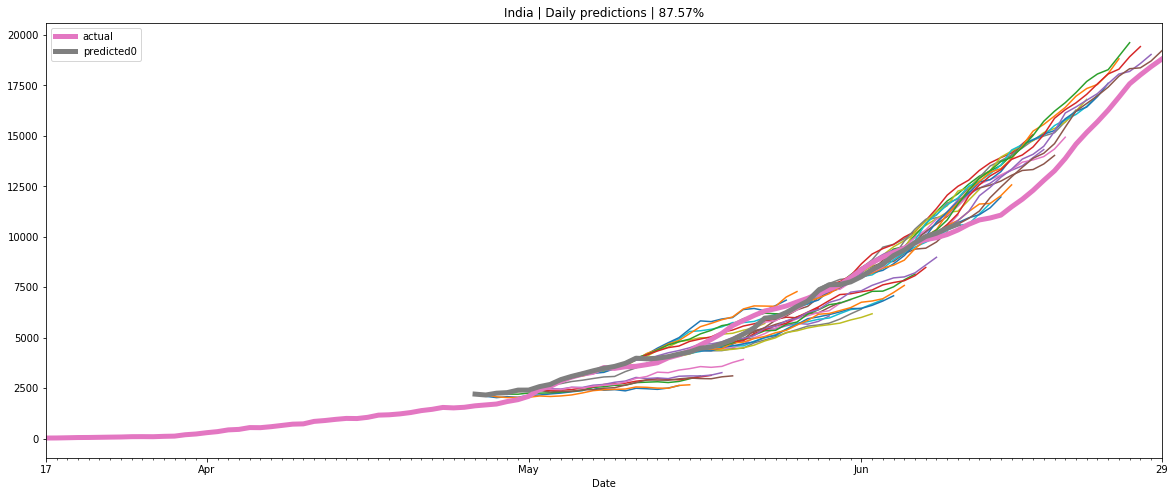

In [25]:
c = "India"
pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000

all_preds = []
pred_vals = []
out_vals = []

test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

for i in range(len(test_data) - IP_SEQ_LEN - OP_SEQ_LEN + 1):
    ip = torch.tensor(test_data[i : i+IP_SEQ_LEN])
    op = torch.tensor(test_data[i+IP_SEQ_LEN : i+IP_SEQ_LEN+OP_SEQ_LEN])
    ip = ip.to(device)
    op = op.to(device)

    pred = model.predict(ip.view(1, IP_SEQ_LEN, 1))    
    if i==0: # prepend first input
        out_vals.extend(ip.view(IP_SEQ_LEN).cpu().numpy() * pop_fct)
        pred_vals.extend([np.NaN] * IP_SEQ_LEN)
    all_preds.append(pred.view(OP_SEQ_LEN).cpu().numpy() * pop_fct)
    pred_vals.append(pred.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)
    out_vals.append(op.view(OP_SEQ_LEN).cpu().numpy()[0] * pop_fct)

# last N-1 values
out_vals.extend(op.view(OP_SEQ_LEN).cpu().numpy()[1:] * pop_fct)
pred_vals.extend(([np.NaN] * OP_SEQ_LEN)[1:]) # pad with NaN

cmp_df = pd.DataFrame({
    'actual': out_vals,
    'predicted0': pred_vals
})

# set date
start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
end_date = start_date + dt.timedelta(days=cmp_df.index[-1])
cmp_df['Date'] = pd.Series([start_date + dt.timedelta(days=i) for i in range(len(cmp_df))])

# plot noodles
ax=None
i=IP_SEQ_LEN
mape=[]
for pred in all_preds:
    cmp_df['predicted_cases'] = np.NaN
    cmp_df.loc[i:i+OP_SEQ_LEN-1, 'predicted_cases'] = pred
    ax = cmp_df.plot(x='Date', y='predicted_cases', ax=ax, legend=False)
    ape = np.array(100 * ((cmp_df['actual'] - cmp_df['predicted_cases']).abs() / cmp_df['actual']))
#     mape.append(ape.mean())
    mape.append(ape[~np.isnan(ape)])
    i+=1

total = np.zeros(OP_SEQ_LEN)
for m in mape:
    total += m
elwise_mape = total / len(mape)
print("Element wise accuracy:", 100 - elwise_mape)
acc = f"{100 - sum(elwise_mape)/len(elwise_mape):0.2f}%"
# acc = f"{100 - sum(mape)/len(mape):0.2f}%"

# plot primary lines
ax = cmp_df.plot(
    x='Date',
    y=['actual', 'predicted0'],
    figsize=(20,8),
    lw=5,
    title=c + ' | Daily predictions | ' + acc,
    ax=ax
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)

### Test (predict) using OWID data

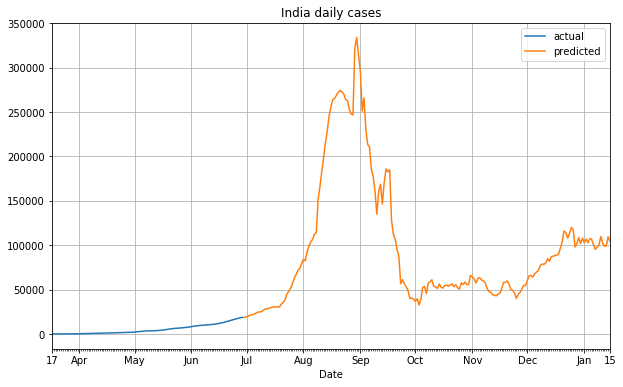

In [14]:
c = "India"
n_days_prediction = 200

pop_fct = df.loc[df.location==c, 'population'].iloc[0] / 1000
test_data = np.array(df.loc[(df.location==c) & (df.total_cases>=100), 'new_cases'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)

in_data = test_data[-IP_SEQ_LEN:]
out_data = np.array([], dtype=np.float32)
for i in range(int(n_days_prediction / OP_SEQ_LEN)):
    ip = torch.tensor(
        in_data,
        dtype=torch.float32
    )
    ip = ip.to(device)
    pred = model.predict(ip.view(1, IP_SEQ_LEN, 1))
    in_data = np.append(in_data[-IP_SEQ_LEN+OP_SEQ_LEN:], pred.cpu().numpy())
    out_data = np.append(out_data, pred.cpu().numpy())

orig_df = pd.DataFrame({
    'actual': test_data * pop_fct
})
fut_df = pd.DataFrame({
    'predicted': out_data * pop_fct
})
# print(fut_df['predicted'].astype('int').to_csv(sep='|', index=False))
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
orig_df['total'] = (orig_df['actual'].fillna(0) + orig_df['predicted'].fillna(0)).cumsum()

start_date = df.loc[(df.location==c) & (df.total_cases>=100)]['date'].iloc[0]
orig_df['Date'] = pd.Series([start_date + dt.timedelta(days=i) for i in range(len(orig_df))])
ax = orig_df.plot(
    x='Date',
    y=['actual', 'predicted'],
    title=c + ' daily cases',
    figsize=(10,6),
    grid=True
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)
# orig_df['total'] = orig_df['total'].astype('int')
# orig_df['predicted'] = orig_df['predicted'].fillna(0).astype('int')
# print(orig_df.tail(n_days))

# arrow
# peakx = 172
# peak = orig_df.iloc[peakx]
# peak_desc = peak['Date'].strftime("%d-%b") + "\n" + str(int(peak['predicted']))
# _ = ax.annotate(
#     peak_desc, 
#     xy=(peak['Date'] - dt.timedelta(days=1), peak['predicted']),
#     xytext=(peak['Date'] - dt.timedelta(days=45), peak['predicted'] * .9),
#     arrowprops={},
#     bbox={'facecolor':'white'}
# )

# _ = ax.axvline(x=peak['Date'], linewidth=1, color='r')

### Statewise prediction

In [92]:
r=rq.get('https://api.covid19india.org/v3/min/timeseries.min.json')
ts = r.json()

data = []
for state in ts:
    for date in ts[state]:
        data.append((state, date, ts[state][date]['total'].get('confirmed', 0)))

states_df = pd.DataFrame(data, columns=['state', 'date', 'total'])
states_df['date'] = pd.to_datetime(states_df['date'])
first_case_date = states_df['date'].min()

In [27]:
# http://www.populationu.com/india-population
STT_INFO = {
    'AN' : {"name": "Andaman & Nicobar Islands", "popn": 450000},
    'AP' : {"name": "Andhra Pradesh", "popn": 54000000},
    'AR' : {"name": "Arunachal Pradesh", "popn": 30000000},
    'AS' : {"name": "Asaam", "popn": 35000000},
    'BR' : {"name": "Bihar", "popn": 123000000},
    'CH' : {"name": "Chandigarh", "popn": 1200000},
    'CT' : {"name": "Chhattisgarh", "popn": 29000000},
    'DL' : {"name": "Delhi", "popn": 19500000},
    'DN' : {"name": "Dadra & Nagar Haveli and Daman & Diu", "popn": 700000},
    'GA' : {"name": "Goa", "popn": 1580000},
    'GJ' : {"name": "Gujarat", "popn": 65000000},
    'HP' : {"name": "Himachal Pradesh", "popn": 7400000},
    'HR' : {"name": "Haryana", "popn": 28000000},
    'JH' : {"name": "Jharkhand", "popn": 38000000},
    'JK' : {"name": "Jammu & Kashmir", "popn": 13600000},
    'KA' : {"name": "Karnataka", "popn": 67000000},
    'KL' : {"name": "Kerala", "popn": 36000000},
    'LA' : {"name": "Ladakh", "popn": 325000},
    'MH' : {"name": "Maharashtra", "popn": 122000000},
    'ML' : {"name": "Meghalaya", "popn": 3400000},
    'MN' : {"name": "Manipur", "popn": 3000000},
    'MP' : {"name": "Madhya Pradesh", "popn": 84000000},
    'MZ' : {"name": "Mizoram", "popn": 1200000},
    'NL' : {"name": "Nagaland", "popn": 2200000},
    'OR' : {"name": "Odisha", "popn": 46000000},
    'PB' : {"name": "Punjab", "popn": 30000000},
    'PY' : {"name": "Puducherry", "popn": 1500000},
    'RJ' : {"name": "Rajasthan", "popn": 80000000},
    'TG' : {"name": "Telangana", "popn": 39000000},
    'TN' : {"name": "Tamil Nadu", "popn": 77000000},
    'TR' : {"name": "Tripura", "popn": 4100000},
    'UP' : {"name": "Uttar Pradesh", "popn": 235000000},
    'UT' : {"name": "Uttarakhand", "popn": 11000000},
    'WB' : {"name": "West Bengal", "popn": 98000000},
#     'SK' : {"name": "Sikkim", "popn": 681000},
#     'UN' : {"name": "Unassigned", "popn": 40000000}, #avg pop
#     'LD' : {"name": "Lakshadweep", "popn": 75000}
}

# uncomment for India
# STT_INFO = {
#     'TT' : {"name": "India", "popn": 1387155000}
# }

#### Dummy state data: fruit country

In [ ]:
# dummy data for testing
# SET 1 - 10 states
# STT_INFO = {
#     'A': {"name": "Apple", "popn": 10000000},
#     'B': {"name": "Berry", "popn": 10000000},
#     'C': {"name": "Cherry", "popn": 10000000},
#     'D': {"name": "Dates", "popn": 10000000},
#     'E': {"name": "Elderberry", "popn": 10000000},
#     'F': {"name": "Fig", "popn": 10000000},
#     'G': {"name": "Grape", "popn": 10000000},
#     'H': {"name": "Honeysuckle", "popn": 10000000},
#     'I': {"name": "Icaco", "popn": 10000000},
#     'J': {"name": "Jujube", "popn": 10000000},
# }
# total = 100
# SET 2 - 1 agg state
STT_INFO = {
    'Z': {"name": "FruitCountry1000x", "popn": 10000000},
}
total = 1000


r = {
    'state': [],
    'date': [],
    'total': []
}

start_date = dt.datetime(day=1, month=3, year=2020)
end_date = dt.datetime.now()
while start_date <= end_date:
    for s in STT_INFO:
        r['state'].append(s)
        r['date'].append(start_date)
        r['total'].append(total)
    total *= 1.03
    start_date += dt.timedelta(days=1)
states_df = pd.DataFrame(r)
states_df['date'] = pd.to_datetime(states_df['date'])
states_df.tail()

#### Predict

In [93]:
def expand(df):
    '''Fill missing dates in an irregular timeline'''
    min_date = df['date'].min()
    max_date = df['date'].max()
    idx = pd.date_range(min_date, max_date)
    
    df.index = pd.DatetimeIndex(df.date)
    df = df.drop(columns=['date'])
    return df.reindex(idx, method='pad').reset_index().rename(columns={'index':'date'})

def prefill(df, min_date):
    '''Fill zeros from first_case_date to df.date.min()'''
    assert(len(df.state.unique()) == 1)
    s = df.state.unique().item()
    min_date = min_date
    max_date = df['date'].max()
    idx = pd.date_range(min_date, max_date)
    
    df.index = pd.DatetimeIndex(df.date)
    df = df.drop(columns=['date'])
    return df.reindex(idx).reset_index().rename(columns={'index':'date'}).fillna({'state':s, 'total':0})

Andaman & Nicobar Islands | Sep 02 | 46 | 2682
Andhra Pradesh | Sep 03 | 8922 | 463938
Arunachal Pradesh | Oct 29 | 4144 | 207133
Asaam | Oct 28 | 4815 | 233044
Bihar | Nov 04 | 17010 | 871777
Chandigarh | Aug 24 | 22 | 1766
Chhattisgarh | Nov 16 | 3962 | 198537
Delhi | Sep 25 | 2435 | 279931
Dadra & Nagar Haveli and Daman & Diu | Oct 02 | 108 | 4451
Goa | Oct 15 | 200 | 18230
Gujarat | Sep 19 | 8957 | 483814
Himachal Pradesh | Oct 28 | 1362 | 56968
Haryana | Sep 01 | 2664 | 254836
Jharkhand | Oct 28 | 5673 | 246258
Jammu & Kashmir | Dec 01 | 1655 | 81044
Karnataka | Nov 19 | 6760 | 524148
Kerala | Oct 08 | 6154 | 270275
Ladakh | Jun 15 | 92 | 2437
Maharashtra | Dec 23 | 23387 | 1525092
Meghalaya | Oct 12 | 270 | 15644
Manipur | Aug 26 | 81 | 4786
Madhya Pradesh | Nov 17 | 14090 | 656442
Mizoram | Nov 24 | 171 | 8661
Nagaland | Dec 27 | 322 | 11112
Odisha | Sep 25 | 4391 | 363695
Punjab | Aug 28 | 4108 | 170385
Puducherry | Aug 10 | 172 | 19512
Rajasthan | Oct 08 | 10362 | 640024
Telan

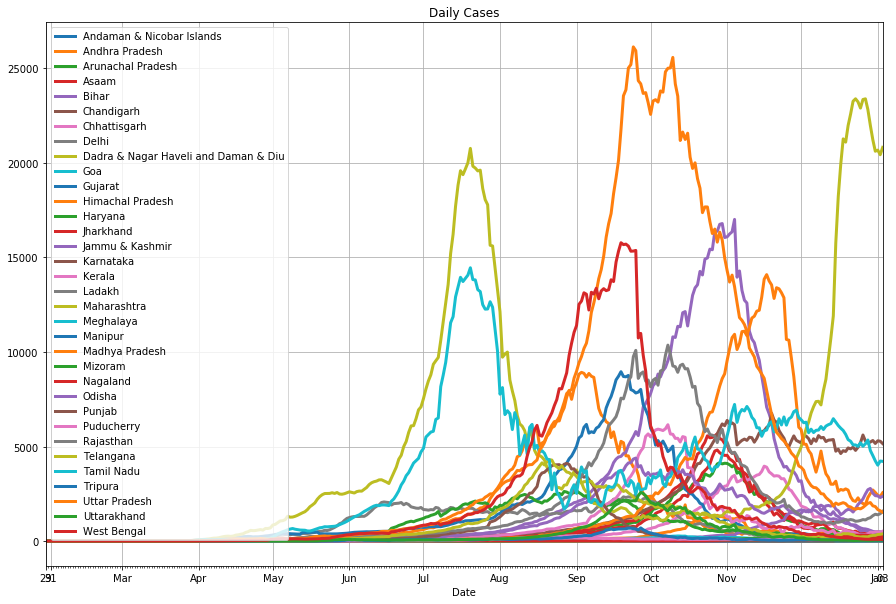

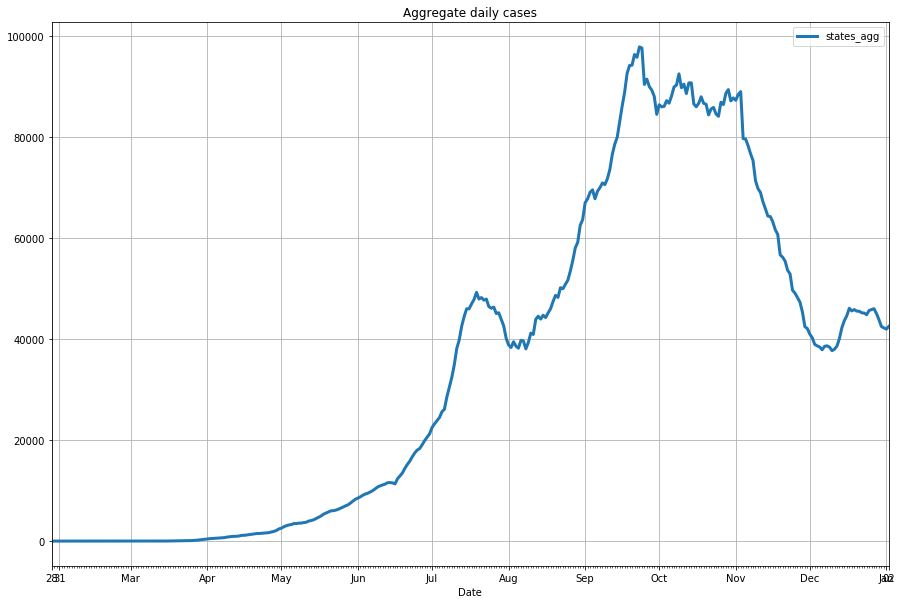

In [138]:
n_days_data = len(expand(states_df.loc[states_df['state']=='TT']))
prediction_offset = 15 # how many days of data to skip
n_days_prediction = 200 # number of days for prediction
if not n_days_prediction%OP_SEQ_LEN == 0:
    raise

agg_days = n_days_data - prediction_offset + n_days_prediction # number of days for plotting agg curve i.e. prediction + actual data 
states_agg = np.zeros(agg_days)

ax = None
api = {}
for state in STT_INFO:
    pop_fct = STT_INFO[state]["popn"] / 1000
    
    state_df = states_df.loc[states_df['state']==state][:-prediction_offset] # skip todays data. covid19 returns incomplete.
    state_df = prefill(expand(state_df), first_case_date)
    state_df['daily'] = state_df['total'] - state_df['total'].shift(1).fillna(0)
    test_data = np.array(state_df['daily'].rolling(7, center=True, min_periods=1).mean() / pop_fct, dtype=np.float32)
    
    in_data = test_data[-IP_SEQ_LEN:]
    out_data = np.array([], dtype=np.float32)
    for i in range(int(n_days_prediction / OP_SEQ_LEN)):
        ip = torch.tensor(
            in_data,
            dtype=torch.float32
        ).to(device)
        try:
            pred = model.predict(ip.view(-1, IP_SEQ_LEN, 1))
        except Exception as e:
            print(state, e)
        in_data = np.append(in_data[-IP_SEQ_LEN+OP_SEQ_LEN:], pred.cpu().numpy())
        out_data = np.append(out_data, pred.cpu().numpy())
    
    sn = STT_INFO[state]['name']
    orig_df = pd.DataFrame({
        'actual': np.array(test_data * pop_fct, dtype=np.int)
    })
    fut_df = pd.DataFrame({
        'predicted': np.array(out_data * pop_fct, dtype=np.int)
    })
    # print(fut_df.to_csv(sep='|'))
    orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
    orig_df[sn] = orig_df['actual'].fillna(0) + orig_df['predicted'].fillna(0)
    orig_df['total'] = orig_df[sn].cumsum()
    states_agg += np.array(orig_df[sn][-agg_days:].fillna(0))

    # generate date col for orig_df from state_df
    start_date = state_df['date'].iloc[0]
    orig_df['Date'] = pd.to_datetime([(start_date + dt.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(len(orig_df))])
#     if orig_df[sn].max() < 10000: # or orig_df[sn].max() < 5000:
#         continue
    
    # print state, peak date, peak daily cases, cumulative since beginning
    peak = orig_df.loc[orig_df[sn].idxmax()]
    print(sn, "|", peak['Date'].strftime("%b %d"), "|", int(peak[sn]), "|", int(orig_df['total'].iloc[-1]))
    
    # export data for API
    orig_df['deceased_daily'] = orig_df[sn] * 0.028
    orig_df['recovered_daily'] = orig_df[sn].shift(14, fill_value=0) - orig_df['deceased_daily'].shift(7, fill_value=0)
    orig_df['active_daily'] = orig_df[sn] - orig_df['recovered_daily'] - orig_df['deceased_daily']
    
    api[state] = {}
    for idx, row in orig_df[-agg_days:].iterrows():
        row_date = row['Date'].strftime("%Y-%m-%d")
        api[state][row_date] = {
            "delta": {
                "confirmed": int(row[sn]),
                "deceased": int(row['deceased_daily']),
                "recovered": int(row['recovered_daily']),
                "active": int(row['active_daily'])
            }
        }
        
    # plot state chart
    ax = orig_df.plot(
        x='Date',
        y=[sn],
        title='Daily Cases',
        figsize=(15,10),
        grid=True,
        ax=ax,
        lw=3
    )
    mn_l = DayLocator()
    ax.xaxis.set_minor_locator(mn_l)
    mj_l = AutoDateLocator()
    mj_f = ConciseDateFormatter(mj_l, show_offset=False)
    ax.xaxis.set_major_formatter(mj_f)

# plot aggregate chart
cum_df = pd.DataFrame({
    'states_agg': states_agg 
})
last_date = orig_df['Date'].iloc[-1].to_pydatetime()
start_date = last_date - dt.timedelta(days=agg_days)
cum_df['Date'] = pd.to_datetime([(start_date + dt.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(len(cum_df))])
ax = cum_df.plot(
    x='Date',
    y=['states_agg'],
    title='Aggregate daily cases',
    figsize=(15,10),
    grid=True,
    lw=3
)
mn_l = DayLocator()
ax.xaxis.set_minor_locator(mn_l)
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
ax.xaxis.set_major_formatter(mj_f)

# plot peak in agg
# peakx = 171
# peak = cum_df.iloc[peakx]
# peak_desc = peak['Date'].strftime("%d-%b") + "\n" + str(int(peak['states_agg']))
# _ = ax.annotate(
#     peak_desc, 
#     xy=(peak['Date'] + dt.timedelta(days=1), peak['states_agg']),
#     xytext=(peak['Date'] + dt.timedelta(days=45), peak['states_agg'] * .9),
#     arrowprops={},
#     bbox={'facecolor':'white'}
# )
# _ = ax.axvline(x=peak['Date'], linewidth=1, color='r')

#### Export JSON for API

In [21]:
# aggregate predictions
api['TT'] = {}
for state in api:
    if state == 'TT':
        continue
    for date in api[state]:
        api['TT'][date] = api['TT'].get(date, {'delta':{}, 'total':{}})
        for k in ['delta']: #'total'
            api['TT'][date][k]['confirmed'] = api['TT'][date][k].get('confirmed', 0) + api[state][date][k]['confirmed']
            api['TT'][date][k]['deceased'] = api['TT'][date][k].get('deceased', 0) + api[state][date][k]['deceased']
            api['TT'][date][k]['recovered'] = api['TT'][date][k].get('recovered', 0) + api[state][date][k]['recovered']
            api['TT'][date][k]['active'] = api['TT'][date][k].get('active', 0) + api[state][date][k]['active']

# export
with open("predictions.json", "w") as f:
    f.write(json.dumps(api, sort_keys=True))

#### Export data for video player

In [139]:
# aggregate predictions
api['TT'] = {}
for state in api:
    if state == 'TT':
        continue
    for date in api[state]:
        api['TT'][date] = api['TT'].get(date, {})
        api['TT'][date]['c'] = api['TT'][date].get('c', 0) + api[state][date]['delta']['confirmed']
        api['TT'][date]['d'] = api['TT'][date].get('d', 0) + api[state][date]['delta']['deceased']
        api['TT'][date]['r'] = api['TT'][date].get('r', 0) + api[state][date]['delta']['recovered']
        api['TT'][date]['a'] = api['TT'][date].get('a', 0) + api[state][date]['delta']['active']

# cumulative
t = {'c':0, 'd':0, 'r':0, 'a':0}
for date in sorted(api['TT'].keys()):
    for k in ['c', 'd', 'r', 'a']:
        api['TT'][date][k] += t[k] # add cum to today
        t[k] = api['TT'][date][k] # udpate cum

# read previous and export
k = (states_df.date.max().to_pydatetime() - dt.timedelta(days=prediction_offset)).strftime("%Y-%m-%d")
try:
    with open("vp.json", "r") as f:
        out = json.loads(f.read())
except Exception as e:
    out = {}

with open("vp.json", "w") as f:
    out[k] = {'TT': api['TT']}
    f.write(json.dumps(out, sort_keys=True))